In [1]:
import scipy as sp
import time
import os
import sys
from scipy import interpolate
from scipy import signal
import scipy.constants as spc
import matplotlib.pyplot as plt
import matplotlib
import GDD
#from GDD import PicoScope as ps # module for pico_scope
# from GDD import ZabberVoiceCoil as zv # module to operate stage 
# from GDD import Fastplot as fp
# import logging
import numpy as np
#import ipywidgets as widgets
#from IPython.display import display
%matplotlib notebook

<IPython.core.display.Javascript object>


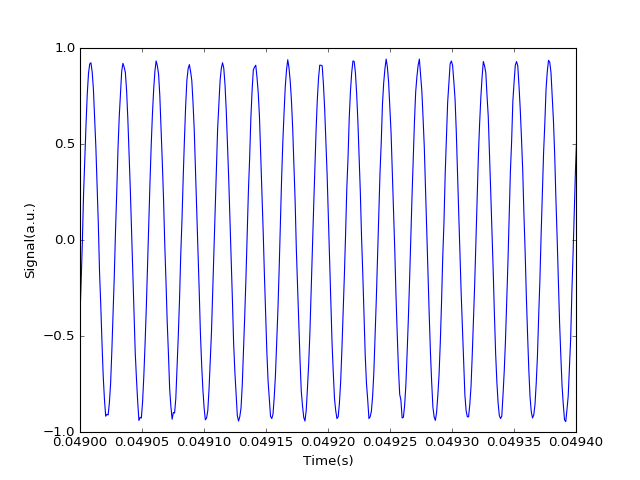

In [28]:
# read data from file
data = sp.load('new_data_19march.npy')
timeS = data[:,0]*1e-9
signal_HeNe = data[:,1]
signal_SC = data[:,2]
N = len(timeS)
D_time = (timeS[-1] - timeS[0])/(len(timeS)-1)
ind_start = 2000
ind_stop = 130000
timeS = timeS[ind_start:ind_stop]
signal_HeNe = signal_HeNe[ind_start:ind_stop]
signal_SC = signal_SC[ind_start:ind_stop]
signal_HeNe=(signal_HeNe-signal_HeNe.mean())/(sp.absolute(signal_HeNe-signal_HeNe.mean())).max() #normalize and shift around zero
signal_SC=(signal_SC-signal_SC.mean())/(sp.absolute(signal_SC-signal_SC.mean())).max()
vel1 = 20 #mm/2
vel2 = 40 #mm/s
scan_distance = 2 #mm

plt.figure()
plt.plot(timeS,signal_HeNe)
#plt.plot(timeS,signal_SC,'g')
plt.xlabel('Time(s)')
plt.xlim(0.0490,0.0494)
plt.ylabel('Signal(a.u.)')
#plt.xlim(0.336,0.376)
plt.savefig('HeNe_int', format = None)

In [192]:
# Init structure

wl_laser = 633e-9
N_FFT = 2**16

z_range = 1e-3
z = sp.linspace(-z_range/2, z_range/2,N_FFT )
dt = (z.max() - z.min())/(len(z)-1) / spc.c 
freq = sp.fftpack.fftfreq(N_FFT,dt)
wl = spc.c / freq
omega = 2 * sp.pi * freq
d_omega = omega[1] - omega[0]
phase_swap = sp.repeat([-1,1],N_FFT/2)

GDD_avg = sp.zeros(N_FFT)
GDD_std = sp.zeros(N_FFT)

GDD_avg_pos = sp.zeros(N_FFT)
GDD_avg_neg = sp.zeros(N_FFT)

i_avg = 0;
i_avg_pos = 0
i_avg_neg = 0



D:\winpython\python\WinPython-64bit-3.5.2.3\python-3.5.2.amd64\lib\site-packages\ipykernel\__main__.py:10: RuntimeWarning: divide by zero encountered in true_divide


In [219]:
# read Picoscope data

p = ps.DAQ_parallel_channels(Samples_per_channel= 1e6)
timeS,data = p.DAQ_read()
p.DAQ_close()

timeS *=1e-9
signal_HeNe = data[:,0]
signal_SC = data[:,1]
N = len(timeS)
D_time = (timeS[-1] - timeS[0])/(len(timeS)-1)

vel1 = 20 #mm/2
vel2 = 40 #mm/s
scan_distance = 1 #mm



<IPython.core.display.Javascript object>


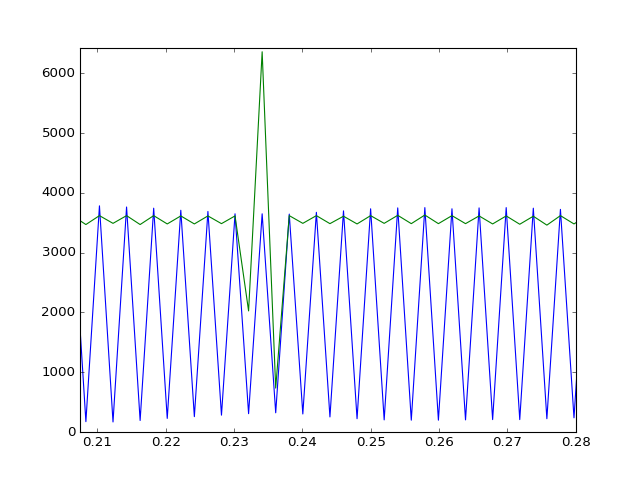

In [220]:
# generate plot data
N_test =int(N/500)
timePlot = timeS[::N_test]
HeNe_plot = sp.zeros_like(timePlot)
for i in sp.arange(0, len(timePlot)-1, 2):
    HeNe_plot[i]=signal_HeNe[(i*N_test):(i*N_test+2*N_test)].max()
for i in sp.arange(1, len(timePlot), 2):
    HeNe_plot[i]=signal_HeNe[(i*N_test):(i*N_test+2*N_test)].min()

SC_plot = sp.zeros_like(timePlot)
for i in sp.arange(0, len(timePlot)-1, 2):
    SC_plot[i]=signal_SC[(i*N_test):(i*N_test+2*N_test)].max()
for i in sp.arange(1, len(timePlot), 2):
    SC_plot[i]=signal_SC[(i*N_test):(i*N_test+2*N_test)].min()


signal_HeNe=(signal_HeNe-signal_HeNe.mean())/(sp.absolute(signal_HeNe-signal_HeNe.mean())).max() #normalize and shift around zero
signal_SC=(signal_SC-signal_SC.mean())/(sp.absolute(signal_SC-signal_SC.mean())).max()

plt.figure()
plt.plot(timePlot,HeNe_plot)
plt.plot(timePlot,SC_plot)

elapsed time : 0.078 s
i processed : 0, time win : 0.048, z win : 0.927mm, vel 24.010mm/s
i processed : 1, time win : 0.037, z win : 0.914mm, vel 32.985mm/s
i processed : 2, time win : 0.048, z win : 0.927mm, vel 24.035mm/s
i processed : 3, time win : 0.037, z win : 0.914mm, vel 32.963mm/s
i processed : 4, time win : 0.048, z win : 0.927mm, vel 24.052mm/s
i processed : 5, time win : 0.037, z win : 0.914mm, vel 32.953mm/s
i processed : 6, time win : 0.048, z win : 0.927mm, vel 24.022mm/s
i processed : 7, time win : 0.037, z win : 0.914mm, vel 32.977mm/s
i processed : 8, time win : 0.048, z win : 0.927mm, vel 24.030mm/s
i processed : 9, time win : 0.037, z win : 0.914mm, vel 33.015mm/s
i processed : 11, time win : 0.048, z win : 0.927mm, vel 24.042mm/s
i processed : 12, time win : 0.037, z win : 0.914mm, vel 32.983mm/s
i processed : 13, time win : 0.048, z win : 0.927mm, vel 24.023mm/s
i processed : 14, time win : 0.037, z win : 0.914mm, vel 33.029mm/s


<IPython.core.display.Javascript object>


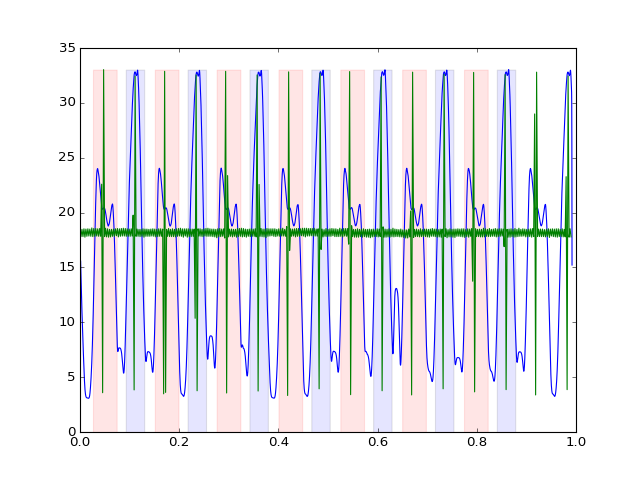

elapsed time : 0.223 s


In [221]:


t0 = time.time()


signal_HeNe[sp.where(signal_HeNe==0)] = sys.float_info.epsilon#1e-100 #works with sign even if smaller than epsilon
zero_crossings = sp.append(0,sp.absolute(sp.diff(sp.sign(signal_HeNe)))) > 0#the [] is important to only get the indizes back
inds_z = sp.where(zero_crossings)[0]

time_z = timeS[inds_z]
pos = sp.arange(0,len(inds_z))*wl_laser/4 * 1e3
vel = sp.append(0,sp.diff(pos)/sp.diff(time_z))
    
kern_win_size = 501  # it was 2001 
x_kern = sp.linspace(-6,6,kern_win_size)
kern = sp.exp(-x_kern**2/4)
kern /= kern.sum() # equivalent to kern = kern/kern.sum()

vel_filt = sp.convolve(vel, kern, mode='same') #gaussian filter
speed_threshold = vel_filt.max() * 0.3 # threshold at 5% of speed
speed_win = vel_filt > speed_threshold


win_diff = sp.append(0,sp.diff(sp.array(speed_win,'int')))
start_ind_z = sp.where(win_diff > 0)[0][1:-1]
stop_ind_z = sp.where(win_diff < 0)[0][1:-1]

if start_ind_z[0] > stop_ind_z[0]:
    stop_ind_z = stop_ind_z[1:]

if start_ind_z[-1] > stop_ind_z[-1]:
    start_ind_z = start_ind_z[:-1]

if len(start_ind_z) != len(stop_ind_z):
    print('start_ind and stop_ind not the same length.')
print('elapsed time : {:0.3f} s'.format(time.time()-t0))

# separate scans
vel_thresh = (vel1 + vel2) /2
ind_start = []
ind_stop = []
scan_direction = []

pos_scan_plot = sp.zeros_like(time_z)
neg_scan_plot = sp.zeros_like(time_z)

for i in range(len(start_ind_z)):
    win_time_span = time_z[stop_ind_z[i]] - time_z[start_ind_z[i]]
    z_span = pos[stop_ind_z[i]] - pos[start_ind_z[i]]
    if z_span < scan_distance*0.9:
        continue        
    win_max_vel = vel_filt[start_ind_z[i]:stop_ind_z[i]].max()
    print('i processed : {}, time win : {:0.3f}, z win : {:.3f}mm, vel {:.3f}mm/s'\
          .format(i,win_time_span,z_span,win_max_vel))
    ind_start.append(inds_z[start_ind_z[i]])
    ind_stop.append(inds_z[stop_ind_z[i]])
    if win_max_vel > vel_thresh:
        scan_direction.append(-1)
        pos_scan_plot[start_ind_z[i]:stop_ind_z[i]] = 1
    else:
        scan_direction.append(1)
        neg_scan_plot[start_ind_z[i]:stop_ind_z[i]] = 1
        
plt.figure()
# plt.plot(timeS,zero_crossings)
# plt.plot(timeS,MA)
plt.fill_between(time_z,pos_scan_plot * vel_filt.max(),alpha = 0.1)
plt.fill_between(time_z,neg_scan_plot * vel_filt.max(),color = 'r',alpha = 0.1)

# plt.plot(time_z,vel)
plt.plot(time_z,vel_filt)

plt.plot(timePlot,SC_plot/SC_plot.max()* vel_filt.max())
# plt.plot(timeS[stop_ind],sp.zeros(len(stop_ind)),'k.')
# plt.plot(timePlot,SC_plot / 1e4)
# plt.show()

print('elapsed time : {:0.3f} s'.format(time.time()-t0))

<IPython.core.display.Javascript object>


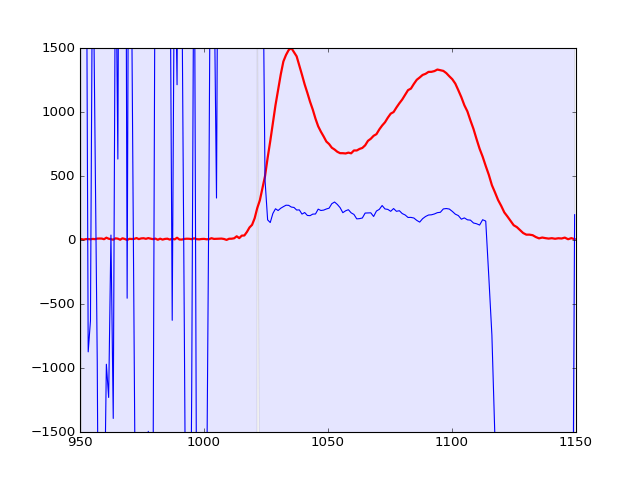

z_range = 1.825
z_range = 1.852
z_range = 1.824
z_range = 1.853
z_range = 1.825
z_range = 1.853
z_range = 1.824
z_range = 1.853
z_range = 1.824
z_range = 1.852
z_range = 1.823
z_range = 1.852
z_range = 1.823
z_range = 1.852
z_range = 1.824
z_range = 1.852
z_range = 1.825
z_range = 1.852
z_range = 1.824
z_range = 1.852
z_range = 1.825
z_range = 1.852
z_range = 1.825
z_range = 1.852
z_range = 1.824
z_range = 1.852
z_range = 1.824
z_range = 1.852
z_range = 1.825
z_range = 1.852
z_range = 1.825
z_range = 1.853
z_range = 1.825
z_range = 1.852
z_range = 1.824
z_range = 1.852
z_range = 1.824
z_range = 1.852
z_range = 1.825
z_range = 1.852
z_range = 1.824
z_range = 1.852
z_range = 1.824
z_range = 1.852
z_range = 1.825
z_range = 1.852
z_range = 1.825
z_range = 1.852
z_range = 1.825
z_range = 1.851
z_range = 1.826
z_range = 1.853
z_range = 1.824
z_range = 1.852
z_range = 1.825
z_range = 1.852
z_range = 1.824
z_range = 1.852
z_range = 1.824
z_range = 1.852
z_range = 1.824
z_range = 1.852
z_range 

356

In [212]:
wl_laser = 633e-9
N_FFT = 2**16

plt.figure()
pl_mask = (wl > 950e-9)*(wl < 1150e-9)


# scan evaluation
for i in range(len(ind_start)):
    time_win = timeS[ind_start[i]:ind_stop[i]]
    signal_HeNe_win = signal_HeNe[ind_start[i]:ind_stop[i]]
    signal_SC_win = signal_SC[ind_start[i]:ind_stop[i]]
    
    intz = sp.where(sp.absolute(sp.diff(sp.sign(signal_HeNe_win))))[0]
    #solve issue if end of array problem
    if intz[-1]==(len(time_win)-1):
        intz=intz[:-1]
   
    #linear interpolated zeros
    time0s = time_win[intz]+signal_HeNe_win[intz]*D_time/(signal_HeNe_win[intz]-signal_HeNe_win[intz+1])
    position_0s = sp.arange(0,len(time0s))*wl_laser/2
    z_scanned = position_0s.max() - position_0s.min()
    print('z_range = {:0.3f}'.format(z_scanned*1e3))
    if z_scanned < z_range:
        continue

    f = interpolate.interp1d(time0s,position_0s)
    mask = (time_win > time0s.min()) & (time_win < time0s.max())
    time_win_valid = time_win[mask]
    pos_interp = f(time_win_valid)
    pos_interp = (pos_interp - (pos_interp.max() - pos_interp.min())/2) * scan_direction[i]
    
       
    # interpolate the SC data into z
    f_interp_SC = interpolate.interp1d(pos_interp, signal_SC_win[mask])
    signal_SC_win_interpalated = f_interp_SC(z)
    
    spect_smp = sp.fft(signal_SC_win_interpalated) * phase_swap
    spectra = sp.absolute(spect_smp)/sp.absolute(spect_smp).max()
    phase_smp = sp.angle(spect_smp)
    phase_smp = sp.unwrap(phase_smp)
    GDD_smp = sp.append(sp.append(0,sp.diff(phase_smp,2)),0)/d_omega**2 
    GDD_avg = (GDD_avg*i+sp.convolve(GDD_smp, sp.ones(3)/3, mode='same'))/(i+1)
    GDD_std = sp.sqrt(1/(i_avg+1)*(GDD_std**2*(i_avg)+(GDD_smp-GDD_avg)**2))#is not the standard 
                                                #definition since for each step the final avg is not known.
    # separate positive and negative scan direction - just for testing
    
    if scan_direction[i] > 0:
        GDD_avg_pos = (GDD_avg_pos*i_avg_pos+sp.convolve(GDD_smp, sp.ones(3)/3, mode='same'))/(i_avg_pos+1)
        i_avg_pos +=1
    else:
        GDD_avg_neg = (GDD_avg_neg*i_avg_neg+sp.convolve(GDD_smp, sp.ones(3)/3, mode='same'))/(i_avg_neg+1)
        i_avg_neg +=1
    i_avg +=1
    
#     plt.plot(z,signal_SC_win_interpalated)
#     plt.plot(wl[pl_mask]*1e9, GDD_smp[pl_mask] * 1e30,lw=2)
#     plt.plot(wl[pl_mask]*1e9, phase_smp[pl_mask])
#plt.ylabel('signal (a.u)')
#plt.xlabel('z (s)')
plt.plot(wl[pl_mask]*1e9, spectra[pl_mask] *1500, 'r',lw=2)
gdd_plot = sp.convolve(GDD_avg, sp.ones(9)/9, mode='same')[pl_mask]*1e30

plt.plot(wl[pl_mask]*1e9,gdd_plot)
plt.fill_between(wl[pl_mask]*1e9, gdd_plot - GDD_std[pl_mask]*1e30, gdd_plot + GDD_std[pl_mask]*1e30, alpha = 0.1)

plt.ylim(-1500,1500)
# plt.grid()
i_avg
   

<IPython.core.display.Javascript object>


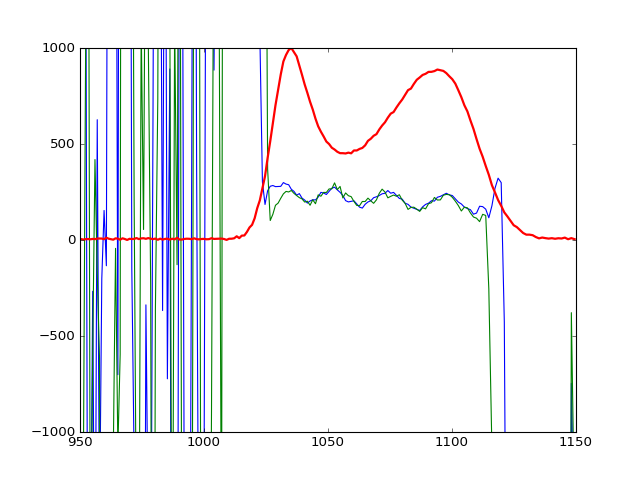

(-1000, 1000)

In [213]:
plt.figure()

plt.plot(wl[pl_mask]*1e9,sp.convolve(GDD_avg_pos, sp.ones(9)/9, mode='same')[pl_mask]*1e30)
plt.plot(wl[pl_mask]*1e9,sp.convolve(GDD_avg_neg, sp.ones(9)/9, mode='same')[pl_mask]*1e30)
# plt.plot(wl[pl_mask]*1e9,sp.convolve(GDD_avg, sp.ones(9)/9, mode='same')[pl_mask]*1e30,'r')
plt.plot(wl[pl_mask]*1e9, spectra[pl_mask] *1000,lw=2)

plt.ylim(-1000,1000)

In [216]:
data_save = sp.transpose([wl[pl_mask]*1e9, GDD_avg[pl_mask]*1e30])



In [218]:
sp.savetxt('speed_difference_data_1.txt',data_save,newline='\r\n', delimiter=', ',header='Wavelength (nm), GDD avearged (fs^2)')